## Import

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

# Label encode labels
from sklearn.preprocessing import LabelEncoder

## Functions

In [2]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [3]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## Download the PubMed 200k RCT dataset

The **PubMed 200k RCT** dataset is described in *Franck Dernoncourt, Ji Young Lee. [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071). International Joint Conference on Natural Language Processing (IJCNLP). 2017.*

In [4]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

## Review the data

In [5]:
base_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

filenames = [base_dir + filename for filename in os.listdir(base_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [6]:
def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [7]:
train_lines = get_lines(base_dir + 'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Preprocess the data

In [8]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    
    return abstract_samples

In [9]:
train_samples = preprocess_text_with_line_numbers(base_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(base_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(base_dir + 'test.txt')

print('Train num:', len(train_samples))
print('Val num:', len(val_samples))
print('Test num:', len(test_samples))

Train num: 180040
Val num: 30212
Test num: 30135


In [10]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### Prepare sentences

In [12]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

### Prepare labels

#### One-hot code labels

In [13]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

print('One-hot encode labels:')
train_labels_one_hot

One-hot encode labels:


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### Label encode labels

In [14]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

print('Label encode labels:')
train_labels_encoded

Label encode labels:


array([3, 2, 2, ..., 4, 1, 1])

### Prepare classes

In [15]:
class_names = label_encoder.classes_
num_classes = len(class_names)

print(f'There are {num_classes} classes: {class_names}')

There are 5 classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Tokenization/Vectorization

### `Token`-level vectorizer

In [16]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]

# Average number of tokens (words) in the training tweets
# max_len = round(sum([len(sentence.split()) for sentence in train_sentences]) / len(train_sentences))

# Number of sentences length cover 95% of samples
max_len = int(np.percentile(sent_lens, 95))

# taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf
max_vocab_len = 68000

text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_len, # bounded the number of most occurrences of words (auto add <OOV>)
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None, # groups of n-words
    output_mode='int', # how to map tokens to numbers
    output_sequence_length=max_len, # how long the sequences to be
    pad_to_max_tokens=True
)

# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

# Get all the unique words in our training data
words_in_vocab = text_vectorizer.get_vocabulary()
count = 5
print(f'The most common {count} words are: {words_in_vocab[:count]}')
print(f'The least common {count} words are: {words_in_vocab[-count:]}')

The most common 5 words are: ['', '[UNK]', 'the', 'and', 'of']
The least common 5 words are: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### `Character`-level vectorizer

In [17]:
def split_chars(text):
    return ' '.join(list(text))

In [18]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [19]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and <OOV>

# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]

# Number of character length cover 95% of samples
max_len = int(np.percentile(char_lens, 95))

char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS, # bounded the number of most occurrences of words (auto add <OOV>)
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None, # groups of n-words
    output_mode='int', # how to map tokens to numbers
    output_sequence_length=max_len, # how long the sequences to be
    pad_to_max_tokens=True
)

# Fit the text vectorizer to the training character
char_vectorizer.adapt(train_chars)

# Get all the unique words in our training data
char_vocab = char_vectorizer.get_vocabulary()
count = 5
print(f'The most common {count} words are: {char_vocab[:count]}')
print(f'The least common {count} words are: {char_vocab[-count:]}')

The most common 5 words are: ['', '[UNK]', 'e', 't', 'i']
The least common 5 words are: ['k', 'x', 'z', 'q', 'j']


## Creating datasets (making sure the data loads as fast as possible)

### `Token`-level dataset

In [20]:
# Turn data into TensorFlow Datasets
train_token_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_token_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_token_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_token_batches = train_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_batches = val_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_token_batches = test_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### `Char`-level dataset

In [21]:
# Turn data into TensorFlow Datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

train_char_batches = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_batches = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_batches = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Hybrid `Token-Char`-level dataset

In [22]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine data and labels

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels)) # combine data and labels

test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)) # make data
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make labels
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels)) # combine data and labels

train_token_char_batches = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_batches = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_token_char_batches = test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Tribrid `Token-Char-Positional`-level dataset

#### Setup `Positional` Embeddings
This is feature engineering.

##### One-hot encoded for `line_number`

In [35]:
# train_df['line_number'].value_counts()
np.percentile(train_df.line_number, 98)

15.0

In [36]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

##### One-hot encoded for `total_lines`

In [38]:
# train_df['total_lines'].value_counts()
np.percentile(train_df.total_lines, 98)

20.0

In [39]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

#### Tribrid datasets
Token + Char + line_number (one-hot) + total_lines (one-hot)

In [40]:
train_token_char_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_number_one_hot, train_total_lines_one_hot)) # make data
train_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_token_char_pos_dataset = tf.data.Dataset.zip((train_token_char_pos_data, train_token_char_pos_labels)) # combine data and labels

val_token_char_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_number_one_hot, val_total_lines_one_hot)) # make data
val_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_token_char_pos_dataset = tf.data.Dataset.zip((val_token_char_pos_data, val_token_char_pos_labels)) # combine data and labels

test_token_char_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, test_line_number_one_hot, test_total_lines_one_hot)) # make data
test_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # make labels
test_token_char_pos_dataset = tf.data.Dataset.zip((test_token_char_pos_data, test_token_char_pos_labels)) # combine data and labels

train_token_char_pos_batches = train_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_pos_batches = val_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_token_char_pos_batches = test_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## CNN model experiment

### Build a CNN model with `token`-level embeddings

In [24]:
token_embeddings = tf.keras.layers.Embedding(
    input_dim=len(words_in_vocab), # input shape
    output_dim=128, # output shape, means each token gets represented by a vector 128 long
    input_length=max_len, # how long is each input
    mask_zero=True, # efficient computing when the vectorized sentences padded with lots of 0
    name='token_embedding_layer'
)

input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(input_layer)
x = token_embeddings(x)
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

cnn_token_model = tf.keras.Model(input_layer, output_layer)

cnn_token_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

cnn_token_model_history = cnn_token_model.fit(
    train_token_batches,
    steps_per_epoch=int(0.1 * len(train_token_batches)),
    epochs=3,
    validation_data=val_token_batches,
    validation_steps=int(0.1 * len(val_token_batches))
)

Epoch 1/3
562/562 [==============================] - 12s 20ms/step - loss: 0.8436 - accuracy: 0.6809 - val_loss: 0.5907 - val_accuracy: 0.7799
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.5784 - accuracy: 0.7879 - val_loss: 0.5387 - val_accuracy: 0.7972
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.5440 - accuracy: 0.7996 - val_loss: 0.5214 - val_accuracy: 0.8085


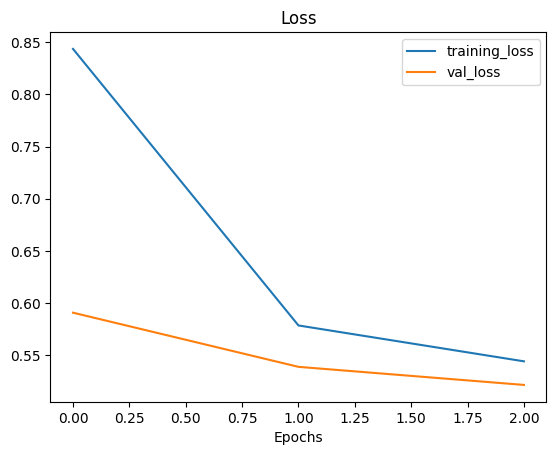

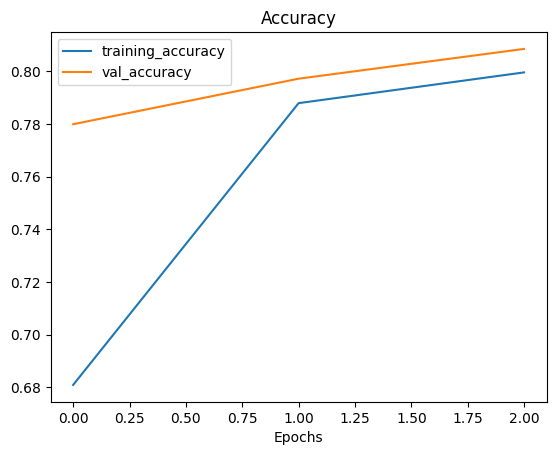

In [25]:
plot_loss_curves(cnn_token_model_history)

#### Evaluate the model

In [26]:
eval = cnn_token_model.evaluate(test_token_batches, verbose=1)

for name, value in zip(cnn_token_model.metrics_names, eval):
  print("%s: %.10f" % (name, value))

942/942 [==============================] - 6s 6ms/step - loss: 0.5388 - accuracy: 0.8008
loss: 0.5388077497
accuracy: 0.8008295894


#### Predictions

In [27]:
pred_probs = cnn_token_model.predict(test_token_batches)
preds = tf.argmax(pred_probs, axis=1)
preds[:10]

942/942 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 0, 1, 1], dtype=int64)>

In [28]:
results = calculate_results(test_labels_encoded, preds)
results

{'accuracy': 80.0829600132736,
 'precision': 0.7992546637127959,
 'recall': 0.8008296001327361,
 'f1': 0.79922019444659}

### Build a CNN model with `char`-level embeddings

In [25]:
char_embeddings = tf.keras.layers.Embedding(
    input_dim=len(char_vocab), # input shape
    output_dim=25, # output shape, means each char gets represented by a vector 25 long (25 mentioned in paper)
    mask_zero=True, # efficient computing when the vectorized sentences padded with lots of 0
    name='char_embedding_layer'
)

input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(input_layer)
x = char_embeddings(x)
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

cnn_char_model = tf.keras.Model(input_layer, output_layer)

cnn_char_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

cnn_char_model_history = cnn_char_model.fit(
    train_char_batches,
    steps_per_epoch=int(0.1 * len(train_char_batches)),
    epochs=3,
    validation_data=val_char_batches,
    validation_steps=int(0.1 * len(val_char_batches))
)

Epoch 1/3
562/562 [==============================] - 13s 9ms/step - loss: 1.2636 - accuracy: 0.4934 - val_loss: 1.0387 - val_accuracy: 0.5904
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9996 - accuracy: 0.5995 - val_loss: 0.9453 - val_accuracy: 0.6297
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9276 - accuracy: 0.6335 - val_loss: 0.8783 - val_accuracy: 0.6546


#### Evaluate the model

In [29]:
eval = cnn_char_model.evaluate(test_char_batches, verbose=1)

for name, value in zip(cnn_char_model.metrics_names, eval):
  print("%s: %.10f" % (name, value))

942/942 [==============================] - 4s 5ms/step - loss: 0.8922 - accuracy: 0.6571
loss: 0.8922041059
accuracy: 0.6571096778


#### Predictions

In [30]:
pred_probs = cnn_char_model.predict(test_char_batches)
preds = tf.argmax(pred_probs, axis=1)
preds[:10]

942/942 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 2, 2, 2, 4, 4, 1, 1, 4, 1], dtype=int64)>

In [31]:
results = calculate_results(test_labels_encoded, preds)
results

{'accuracy': 65.71096731375478,
 'precision': 0.6531292294423905,
 'recall': 0.6571096731375478,
 'f1': 0.6465611504887283}

## Transfer Learning model experiment

universal-sentence-encoder - https://tfhub.dev/google/universal-sentence-encoder/4
* The input is variable length English text and the output is a **512** dimensional vector

### Pretrained USE model

In [23]:
url = 'https://tfhub.dev/google/universal-sentence-encoder/4' # model fit error: JIT compilation failed
# url = 'https://tfhub.dev/google/nnlm-en-dim50/2'
# url = 'https://tfhub.dev/google/nnlm-en-dim128/2'
# url = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2' # OOM

hub_layer = hub.KerasLayer(url, input_shape=[], dtype=tf.string, trainable=False)

In [32]:
USE_token_model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

USE_token_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

with tf.device('/CPU:0'): # this line fix error
    USE_token_model_history = USE_token_model.fit(
        train_token_batches,
        steps_per_epoch=int(0.1 * len(train_token_batches)),
        epochs=3,
        validation_data=val_token_batches,
        validation_steps=int(0.1 * len(val_token_batches))
    )

Epoch 1/3
562/562 [==============================] - 19s 29ms/step - loss: 0.9532 - accuracy: 0.6377 - val_loss: 0.8056 - val_accuracy: 0.6842
Epoch 2/3
562/562 [==============================] - 21s 38ms/step - loss: 0.7806 - accuracy: 0.6955 - val_loss: 0.7667 - val_accuracy: 0.7001
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7682 - accuracy: 0.7050 - val_loss: 0.7574 - val_accuracy: 0.7045


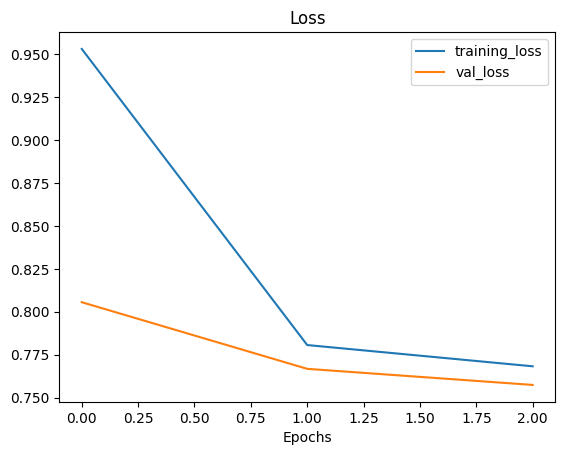

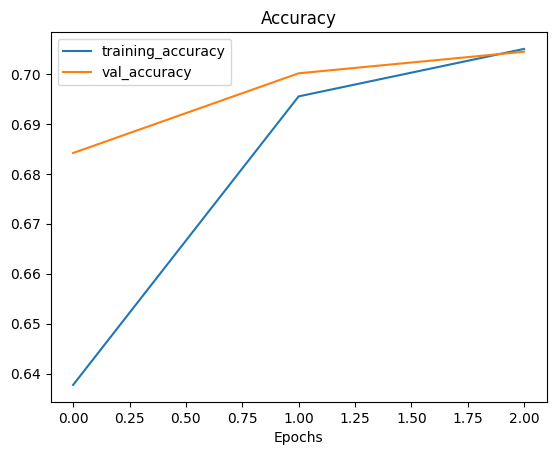

In [33]:
plot_loss_curves(USE_token_model_history)

#### Evaluate the model

In [35]:
with tf.device('/CPU:0'): # this line fix error
  eval = USE_token_model.evaluate(test_token_batches, verbose=1)

for name, value in zip(USE_token_model.metrics_names, eval):
  print("%s: %.10f" % (name, value))

942/942 [==============================] - 28s 29ms/step - loss: 0.7702 - accuracy: 0.7014
loss: 0.7702453732
accuracy: 0.7013771534


#### Predictions

In [36]:
with tf.device('/CPU:0'): # this line fix error
    pred_probs = USE_token_model.predict(test_token_batches)
preds = tf.argmax(pred_probs, axis=1)
preds[:10]

942/942 [==============================] - 29s 30ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 4, 4, 4, 4, 2, 4, 1], dtype=int64)>

In [37]:
results = calculate_results(test_labels_encoded, preds)
results

{'accuracy': 70.13771362203418,
 'precision': 0.7019981508171266,
 'recall': 0.7013771362203418,
 'f1': 0.6981384292884174}

## Hybrid model experiment

`Token` embeddings (pretrained USE model) + `Char` embeddings concatenated model

### Setup `token` embeddings (pretrained USE model)

In [22]:
url = 'https://tfhub.dev/google/universal-sentence-encoder/4' # model fit error: JIT compilation failed
hub_layer = hub.KerasLayer(url, input_shape=[], dtype=tf.string, trainable=False)

In [23]:
USE_token_model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(128, activation='relu')
])

### Setup `char` embeddings

In [26]:
char_embeddings = tf.keras.layers.Embedding(
    input_dim=len(char_vocab), # input shape
    output_dim=25, # output shape, means each char gets represented by a vector 25 long (25 mentioned in paper)
    mask_zero=True, # efficient computing when the vectorized sentences padded with lots of 0
    name='char_embedding_layer'
)

input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(input_layer)
x = char_embeddings(x)
output_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)

char_model = tf.keras.Model(input_layer, output_layer)

### Concatenate `token` and `char` embeddings

In [27]:
token_char_embeddings = tf.keras.layers.Concatenate(name='token_char_embeddings')([USE_token_model.output, char_model.output])

# adding Dropout (mentioned in paper)
z = tf.keras.layers.Dropout(0.5)(token_char_embeddings)

### Build the hybrid model

In [40]:
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

hybrid_model = tf.keras.Model(
    inputs=[USE_token_model.input, char_model.input],
    outputs=output_layer
)

In [46]:
# from tensorflow.keras.utils import plot_model
# plot_model(hybrid_model, show_shapes=True)

In [41]:
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

with tf.device('/CPU:0'): # this line fix error
    hybrid_history = hybrid_model.fit(
        train_token_char_batches,
        steps_per_epoch=int(0.1 * len(train_token_char_batches)),
        epochs=3,
        validation_data=val_token_char_batches,
        validation_steps=int(0.1 * len(val_token_char_batches))
    )

Epoch 1/3
562/562 [==============================] - 137s 231ms/step - loss: 0.8572 - accuracy: 0.6764 - val_loss: 0.6961 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 133s 236ms/step - loss: 0.7388 - accuracy: 0.7175 - val_loss: 0.6684 - val_accuracy: 0.7503
Epoch 3/3
562/562 [==============================] - 134s 239ms/step - loss: 0.7279 - accuracy: 0.7216 - val_loss: 0.6582 - val_accuracy: 0.7547


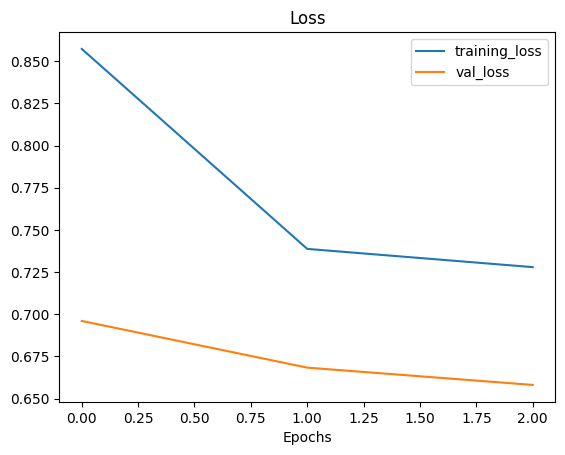

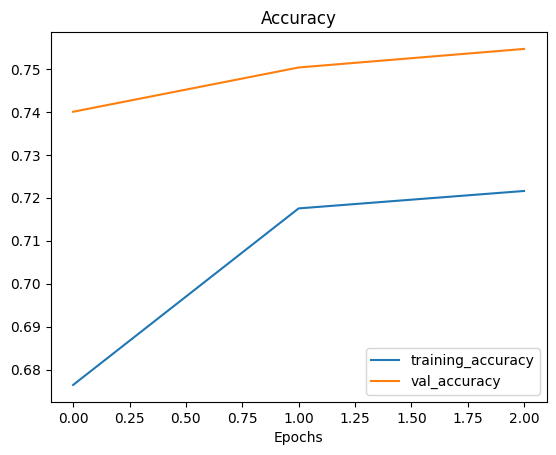

In [42]:
plot_loss_curves(hybrid_history)

### Evaluate the model

In [45]:
with tf.device('/CPU:0'): # this line fix error
  eval = hybrid_model.evaluate(test_token_char_batches, verbose=1)

for name, value in zip(hybrid_model.metrics_names, eval):
  print("%s: %.10f" % (name, value))

942/942 [==============================] - 70s 74ms/step - loss: 0.6815 - accuracy: 0.7385
loss: 0.6814846992
accuracy: 0.7385432124


### Predictions

In [43]:
with tf.device('/CPU:0'): # this line fix error
    pred_probs = hybrid_model.predict(test_token_char_batches)
preds = tf.argmax(pred_probs, axis=1)
preds[:10]

942/942 [==============================] - 80s 81ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 0, 4, 1], dtype=int64)>

In [44]:
results = calculate_results(test_labels_encoded, preds)
results

{'accuracy': 73.85432221669156,
 'precision': 0.7374916691356613,
 'recall': 0.7385432221669156,
 'f1': 0.7355783882498949}

## Advance: Tribrid model experiment
Combined with the following embeddings:
* Token Embeddings (pretrained USE model)
* Char Embeddings
* line number model (positional embeddings)
* total lines model (positional embeddings)

### Setup `Positional` Embeddings
This is feature engineering.

#### One-hot encoded for `line_number`

In [20]:
# train_df['line_number'].value_counts()
np.percentile(train_df.line_number, 98)

15.0

In [21]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [22]:
input_layer = tf.keras.layers.Input(shape=(15,), dtype=tf.float32)
output_layer = tf.keras.layers.Dense(32, activation='relu')(input_layer)

line_number_model = tf.keras.Model(input_layer, output_layer)

#### One-hot encoded for `total_lines`

In [23]:
# train_df['total_lines'].value_counts()
np.percentile(train_df.total_lines, 98)

20.0

In [24]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

In [25]:
input_layer = tf.keras.layers.Input(shape=(20,), dtype=tf.float32)
output_layer = tf.keras.layers.Dense(32, activation='relu')(input_layer)

total_lines_model = tf.keras.Model(input_layer, output_layer)

### Setup `token` embeddings (pretrained USE model)

In [26]:
url = 'https://tfhub.dev/google/universal-sentence-encoder/4' # model fit error: JIT compilation failed
hub_layer = hub.KerasLayer(url, input_shape=[], dtype=tf.string, trainable=False)

In [27]:
USE_token_model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(128, activation='relu')
])

### Setup `char` embeddings

In [28]:
char_embeddings = tf.keras.layers.Embedding(
    input_dim=len(char_vocab), # input shape
    output_dim=25, # output shape, means each char gets represented by a vector 25 long (25 mentioned in paper)
    mask_zero=True, # efficient computing when the vectorized sentences padded with lots of 0
    name='char_embedding_layer'
)

input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(input_layer)
x = char_embeddings(x)
output_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)

char_model = tf.keras.Model(input_layer, output_layer)

### Concatenate `token` and `char` embeddings

In [29]:
token_char_embeddings = tf.keras.layers.Concatenate(name='token_char_embeddings')([USE_token_model.output, char_model.output])

# adding Dropout (mentioned in paper)
z = tf.keras.layers.Dropout(0.5)(token_char_embeddings)

### Concatenate `token_char_embeddings`, `line_number_model` and `total_lines_model`

In [30]:
token_char_pos_embeddings = tf.keras.layers.Concatenate(name='token_char_positional_embeddings')([z, line_number_model.output, total_lines_model.output])

### Build the tribrid model

In [31]:
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(token_char_pos_embeddings)

tribrid_model = tf.keras.Model(
    inputs=[USE_token_model.input, char_model.input, line_number_model.input, total_lines_model.input],
    outputs=output_layer
)

In [32]:
# from tensorflow.keras.utils import plot_model
# plot_model(tribrid_model, show_shapes=True)

In [42]:
tribrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting (specifically for really high confidence)
    metrics=['accuracy']
)

with tf.device('/CPU:0'): # this line fix error
    tribrid_history = tribrid_model.fit(
        train_token_char_pos_batches,
        steps_per_epoch=int(0.1 * len(train_token_char_pos_batches)),
        epochs=3,
        validation_data=val_token_char_pos_batches,
        validation_steps=int(0.1 * len(val_token_char_pos_batches))
    )

Epoch 1/3
562/562 [==============================] - 126s 206ms/step - loss: 1.0460 - accuracy: 0.7660 - val_loss: 0.9865 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 121s 216ms/step - loss: 0.9850 - accuracy: 0.8038 - val_loss: 0.9659 - val_accuracy: 0.8158
Epoch 3/3
562/562 [==============================] - 116s 207ms/step - loss: 0.9720 - accuracy: 0.8121 - val_loss: 0.9589 - val_accuracy: 0.8195


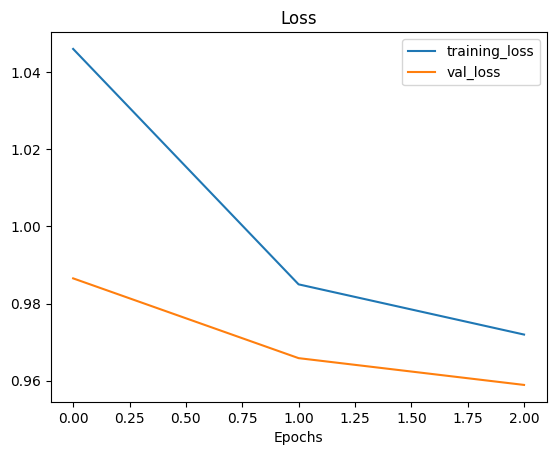

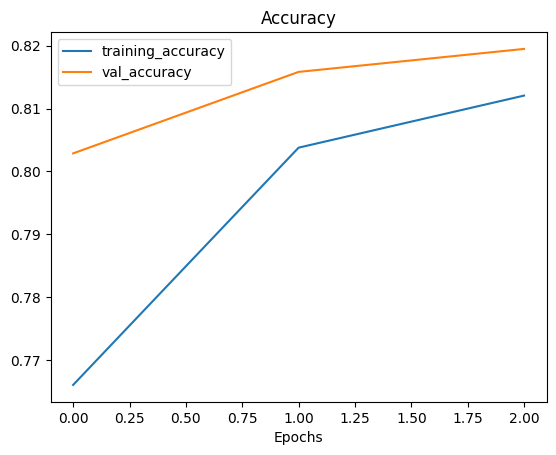

In [43]:
plot_loss_curves(tribrid_history)

### Evaluate the model

In [44]:
with tf.device('/CPU:0'): # this line fix error
  eval = tribrid_model.evaluate(test_token_char_pos_batches, verbose=1)

for name, value in zip(tribrid_model.metrics_names, eval):
  print("%s: %.10f" % (name, value))

942/942 [==============================] - 64s 68ms/step - loss: 0.9630 - accuracy: 0.8156
loss: 0.9630414844
accuracy: 0.8156296611


### Predictions

In [45]:
with tf.device('/CPU:0'): # this line fix error
    pred_probs = tribrid_model.predict(test_token_char_pos_batches)
preds = tf.argmax(pred_probs, axis=1)
preds[:10]

942/942 [==============================] - 70s 71ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0], dtype=int64)>

In [46]:
results = calculate_results(test_labels_encoded, preds)
results

{'accuracy': 81.56296665007467,
 'precision': 0.814548891392016,
 'recall': 0.8156296665007466,
 'f1': 0.8143714786888009}